## Exploring SSA2py: A Case Study of the 2019 Ridgecrest Earthquake

**Authors**: Ioannis Fountoulakis, 2024

Learning Goals:

* Understand the structure of SSA2py
* Review the necessary configuration steps
* Explore the various processing steps required for generating back-projection results
* Execute the code and analyze the results

Estimated time: 1 hour



# What is SSA2py?

SSA2py is an open-source python project that follows the Source-Scanning Algorithm (SSA). It provides interconnection with FDSN Compliant Web Services and it is adapted to run in GPU and CPU multiprocessing architectures. The aim of SSA2py is to provide rapid and accurate calculations of SSA method in near-realtime conditions.

To illustrate the usage of SSA2py the 2019 Mw 7.1 Ridgecrest Earthquake will be analyzed [(details here)](https://earthquake.usgs.gov/earthquakes/eventpage/ci38457511/executive). The exercise runs the workflow step by step to generate back-projection results!


# 0. Initial setup of the notebook


The cells below perform the initial setup of SSA2py and need to be run once.

By the end of this step, the directory structure will look like this:

```
.
├── SSA2py_Ridgecrest.ipynb     (This notebook)
└── SSA2py           (SSA2py main directory)
```




### Install conda for Google Colab

In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()

### Get SSA2py source code from GitHub

In [ ]:
!git clone https://github.com/ifountoul/SSA2py.git

### Create SSA2py conda enviroment and install dependencies

In [ ]:
%cd '/content/SSA2py'

!conda config --add channels conda-forge
!conda env create -f environment.yml
!source activate SSA2PY && pip install ipykernel

# 1. SSA2py full setup

By the end of this step, SSA2py will be fully set up and ready for use.





Let us first take a look at the SSA2py directory:

```
.
├── SSA2py           (SSA2py code)
├── docs             (SSA2py documentation)
├── Case_Studies.zip (Examples)
├── Installation.txt (---)
├── LICENSE          (Package license)
├── README.md        (SSA2py basic info)
├── SSA2py.py        (Main python script)
├── config.yaml      (Example configuration file)
├── enviroment.yml   (Installation)
├── log              (Logging file)
└── logo.jpg         (SSA2py logo)
```

### 1.1 Test Functionality

In [ ]:
!source activate SSA2PY && python SSA2py.py

### 1.2 Make the required directories

In [ ]:
%mkdir 'SSA2py/events'
%mkdir 'SSA2py/tttables'

### 1.3 Download files necessary for plotting

In [ ]:
!source activate SSA2PY && python SSA2py.py --download

# 2. Prepare the tutorial dataset

Now let's examine the input dataset for this notebook, which is contained in the Case_studies.zip file.

In [ ]:
!unzip Case_Studies.zip

Let us first take a look at the Case_Studies/Ridgecrest_2019:

```
.
├── README.txt             (Readme file)
├── configRidgecrest.yaml  (Ridgecrest configuration)
├── stations.txt           (Stations)
└── vmodel.txt             (Velocity model)
```



### 2.1 Configuration file (configRidgecrest.yaml)

Let us now examine important parts the configuration file

**Traveltimes tables calculation**

```
Traveltimes:
  Crustals1D:
    - Filename:
      Elevation: 3
      Depth: 90
      Distance: 350
      Granularity: 1.0
      VPVS: null
      Geobox: null

  Crustals3D:
    - Filename VP:
      Filename VS:
      Depth: 80        
      Distance: 200    
      Granularity: 1.0
      VPVS: 1.73      
      Geobox: null    

  Priority: '1D'    # '1D'/'3D'.
  Phase: ['P', 'S'] # P, S or both
  Package: 'FMM'    # NNLOC/TAUP/FMM
  Save: SSA2py/tttables
  ```

* **Crustals1D**: 1D Velocity Models subsection.
* **Filename**: Path of the Velocity Model.
* **Elevation**: int Calculate traveltime tables reaching this elevation in km. e.g. 3
* **Depth**: float Maximum depth of the traveltime tables (km) e.g. 90.0

* **Distance**: float Maximum distance of the traveltime tables (km) e.g. 250.0

* **Granularity**: float Step for the traveltime calculations (km) e.g. 1.0

* **VPVS**: float/null You can set a Vp/Vs value. In that way, the SSA2py can use this value to calculate S traveltimes. If you set this value the S wave column in the given model will be ignored if exists.

* **Geobox**: (Lon. 1, Lat. 1), (Lon. 2, Lat. 2), (Lon. 3, Lat. 3), (Lon. 4, Lat. 4) The ‘Geobox’ is a polygon that defines the region where a crustal model is going to be used if the initial hypocenter’s location is within it. If ‘Geobox’ is set to null, then this crustal model will be triggered if no other model found (used as default crustal model). Only one crustal model with null ‘Geobox’ can be defined.

* **Priority**: '1D' Available options ‘1D’/’3D’. The ‘Priority’ parameter indicates the crustal models priority. If ‘1D’ the programs start to searching for the best suited model (based on Geobox) on the ‘Crustals1D’ sub-section, and if ‘3D’ on the ‘Crustals3D’ sub-section.

* **Phase**: ['P', 'S'] Available options ‘P’/’S’. Phases to calculate traveltimes.

* **Package**: 'FMM' Available options ‘FMM’/’TAUP’/’NNLOC’. Methods to calculate traveltimes.

* **Available Methods**: ‘FMM’ - Fast Marching Method | ‘TAUP’ - Taup | ‘NNLOC’ - Eikonal finite-difference.

* **Save**: SSA2py/path/to dir Path to save traveltime tables




**Download data**

```
Download Service:
    Inventory:
       - ['FDSNWS', 'IRIS', null]
       - ['FDSNWS', 'NCEDC', null]
       - ['FDSNWS', 'SCEDC', null]

    Stream:
       - ['FDSNWS', 'IRIS', null]
       - ['FDSNWS', 'NCEDC', null]
       - ['FDSNWS', 'SCEDC', null]
```

* **Download Service**: Section dedicated to provide SSA2py with event information, data and metadata.
* **Inventory**: The Inventory refers to the stations’ characteristics such as the poles-zeros, digitizer’s gain etc. Available options ‘FDSNWS’/’StationXML’/’StationYAML’ formats. Multiple sources can be used.

* **Stream**: Stream sub-section refers to the waveforms data. Available options ‘FDSNWS’/’SeedLink’/’SDS’/’MSEED’. Multiple sources can be used.

**Download rules**

```
Download Rules:
    Distance:
       - [6.0, 9.0, [0, 100, ['HN']]]
    Time: [-10,100]
    Components: ['Z23', 'Z12', '123', 'ZNE']
    Stationslist: [True, '']
```
* **Download Rules**: Retrieve channel types based on distance and magnitude rules.

* **Distance**: [minMag, maxMag, [minDist (km), maxDist (km), [channels]]] Distance rules.

* **Time**: [seconds before, seconds after Origin Time] Traces duration.

* **Components**: ['Z23', 'Z12', '123', 'ZNE'] Accepted types of components. Note that SSA2py uses only E,N,Z components, so for that reason rotation based on metadata will be performed.

* **Stationslist**: [True/False, path/to/file] Stations list. If the ‘Stationslist’ parameter is ‘True’ ([True, .txt file Path]) SSA2py uses given information from a text file in order to keep or discard seismic stations. Accepted format in the .txt file is network.station (e.g. HL.KLV.HH) and ‘True’/’False’

**Process streams**


```
Streams:
  Duration: [-20, 100]                  
  Quality Control: []
  Resample: [True, 100]
  Filter:
    - [2, 8]
  Type: 'ENV'
  Type Parameters: [0.5]
  Rotate: False
  Response: False
  Pre Filter: [0.005, 45]
  Quantity: 'VEL'
  Normalize: [True, 1, 1]
  Corrections: [False, 2, '']
  Combine: True
```  

* **Streams**: The ‘Streams’ section is all about the processing of the data, that will be used as input to SSA2py.

* **Duration**: [seconds before, seconds after origin time] Time duration of the trace (in seconds) before and after the origin time (if smaller pad with zeros).

* **Quality Control**: The modules help to choose good quality waveforms.
['TIME', 'SNR', 'CLIP'] The possible inputs are: SNR, TIME, CLIP. Use an empty list [] if no modules need to be set.

* **Resample**: [True/False, freq] If True resample to the given frequency - freq (in Hz) all the traces.

* **Filter**: Bandpass filter for the processed traces
[low_freq, high_freq] e.g. ‘2-8’: Lower limit 2, high 8 Hz (>1). Use [0,0] for no filtering.

* **Type**: 'ENV' Convert wavefroms. Available options ‘ENV’, ‘OBS’, ‘ABS’, ‘STALTA’, ‘KURT’.

* **Rotate**: True/False If True Rotate to the Radial-Transverse system.

* **Response**: True/False Remove Response if True. Poles/zeros info are needed. Response removal is possible only if the user provides STATIONXML file. Data will always convert in m/s2, m/s or m.

* **Pre Filter**: [0.005, 45] Pre-Filter. Usefull for integration/differentiation. Use [0, 0] not to apply.

* **Quantity**: 'ACC' Physical quantity of all traces. Choose between ‘ACC’: Acceleration, ‘DISP’: Displacement, ‘VEL’: Velocity. This process is available also for the raw records by integration/differentiation. Create a uniform dataset concerning the physical quantity. To avoid drifting effects 0.3-30 Hz Bandpass filter is used before integration/differentiation

* **Normalize**: [True/False, input 1, input 2] Normalize the traces if True. Input 1 is the root factor and input 2 the normalization limit.

* **Corrections**: [True/False, input 1, input 2 (if applies)] Correct traces if is True. Input 1 identifies the correction method.

* **Combine**: True/False If True the E and N components will be merged together (or R-T). The new component will be named as H (Horizontal) and can be used as ‘H’ in the Backprojection section. Only for positive data e.g. Envelopes Combination: sqrt( N^2 + E^2).


**Back-projection tuning**
```
Backprojection:
  GPU: False
  NumCPUS: 8
  Grid:
     - [0.0, 9.0, ['box', 80, 80, 0, 50, 1]]
  Selection:
    Components: ['E', 'N', 'H']
    Distance: 90
  Sectors: [2, 1]
  Settings:
    Phase: 'S'
    TTmax: 50
    ScanningTime:
      - [0.0, 9.0, [0, 25]]
    TimeShift: 0.1
    MovingWindow: [0.3, 0.3]
    BrType: 0
    StaThre: 0.9
    bthre: 0.0
    Weight: 0
    Npower: 1
    Normalize Results: False
```

* **Backprojection**: Section about the Source-Scanning Settings.

* **GPU**: True/False If True the SSA will be performed in the GPU. Otherwise the SSA procedure will be hosted by the CPUS.

* **Grid**: Define the SSA grid.
[min. Magnitude, max. Magnitude, ['box', x side length (km), y side length (km), z side starting depth (km), z side ending depth (km),  step (km)]]

* Selection:

* **Components**: [] Denife components to apply SSA. Available options E (East-West), N (North-South), Z (Vertical), T (Transverse), R (Radial).

* **Distance**: float Maximum distance between epicenter and stations to be selected

* **Sectors**: [minSectors, minStations per sector] Minimum sector requirements to run SSA. The parameter has the form of: [minSectors, minStations per sector] 4 sectors of 90 degrees are defined around the given hypocenter. The first number indicates the number of sectors (minSectors), where at least minStations are found, to be considered. The aim of this operator is to prevent SSA executions with weak azimuthal distribution.

* **Settings**: Settings for SSA.

* **Phase**: 'P' or 'S' P or S phase for the BP calculation. Must be consistent with the pre-calculated tttables.

* **TTmax**: float Only traveltimes <= TTmax will be used in brightness calculation. Otherwise if the traveltime between station-grid point exceeds this value the station will be ignored.

* **ScanningTime**: Scanning time before and after the origin time based on the magnitude of the event.
[min. Magnitude, max. Magnitude, [seconds before, seconds after origin time]]

* **TimeShift**: float Time shift for each step (in sec).

* **MovingWindow**: [half window 1, half window 2] Half length of the moving window (in sec).

* **BrType**: 0/1 Available options: 0 - means average of sum between stations (Honn Kao and Shao-Ju Shan, 2007), 1 - means average of multiplication between stations (Modification based on Roessler et. al, 2010)

* **StaThre**: float Only points calculated from (StaThre)% of total stations are kept put 0-1.0 (0-100%). Otherwise grid will be ignored.

* **bthre**: float Only points with brightness >= bthre*bmax will be outputted.

* **Weight**: 0/1 Weighting of the Half length moving window. Available options: 0 - Gaussian weighting, 1 - Equal weighting

* **Npower**: int This will raise the calculated brightness to its N-th root (Check Normalize).

* **Normalize Results**: True/False This will normalize all the results between 0-1

In [11]:
!cp "Case_Studies/Ridgecrest_2019/configRidgecrest.yaml" "."

After copying the Ridgecrest configuration file to the main directory, please follow the 'Case_Studies/Ridgecrest_2019/README.txt' file to properly edit the file. The two important changes we have to update 1) the velocity model path ("/content/SSA2py/Case_Studies/Ridgecrest_2019/vmodel.txt") and 2) the selected stations path ("/content/SSA2py/Case_Studies/Ridgecrest_2019/stations.txt"). In the Components field use only the **E**.

# 3. Execute SSA2py

In [ ]:
!source activate SSA2PY && python SSA2py.py -c configRidgecrest.yaml -e 2019-07-06T03:19:52.000000Z 7.1 Mw 35.766 -117.605 8

# 4. Results analysis

In the next step we will briefly analyze the Ridgecrest results.

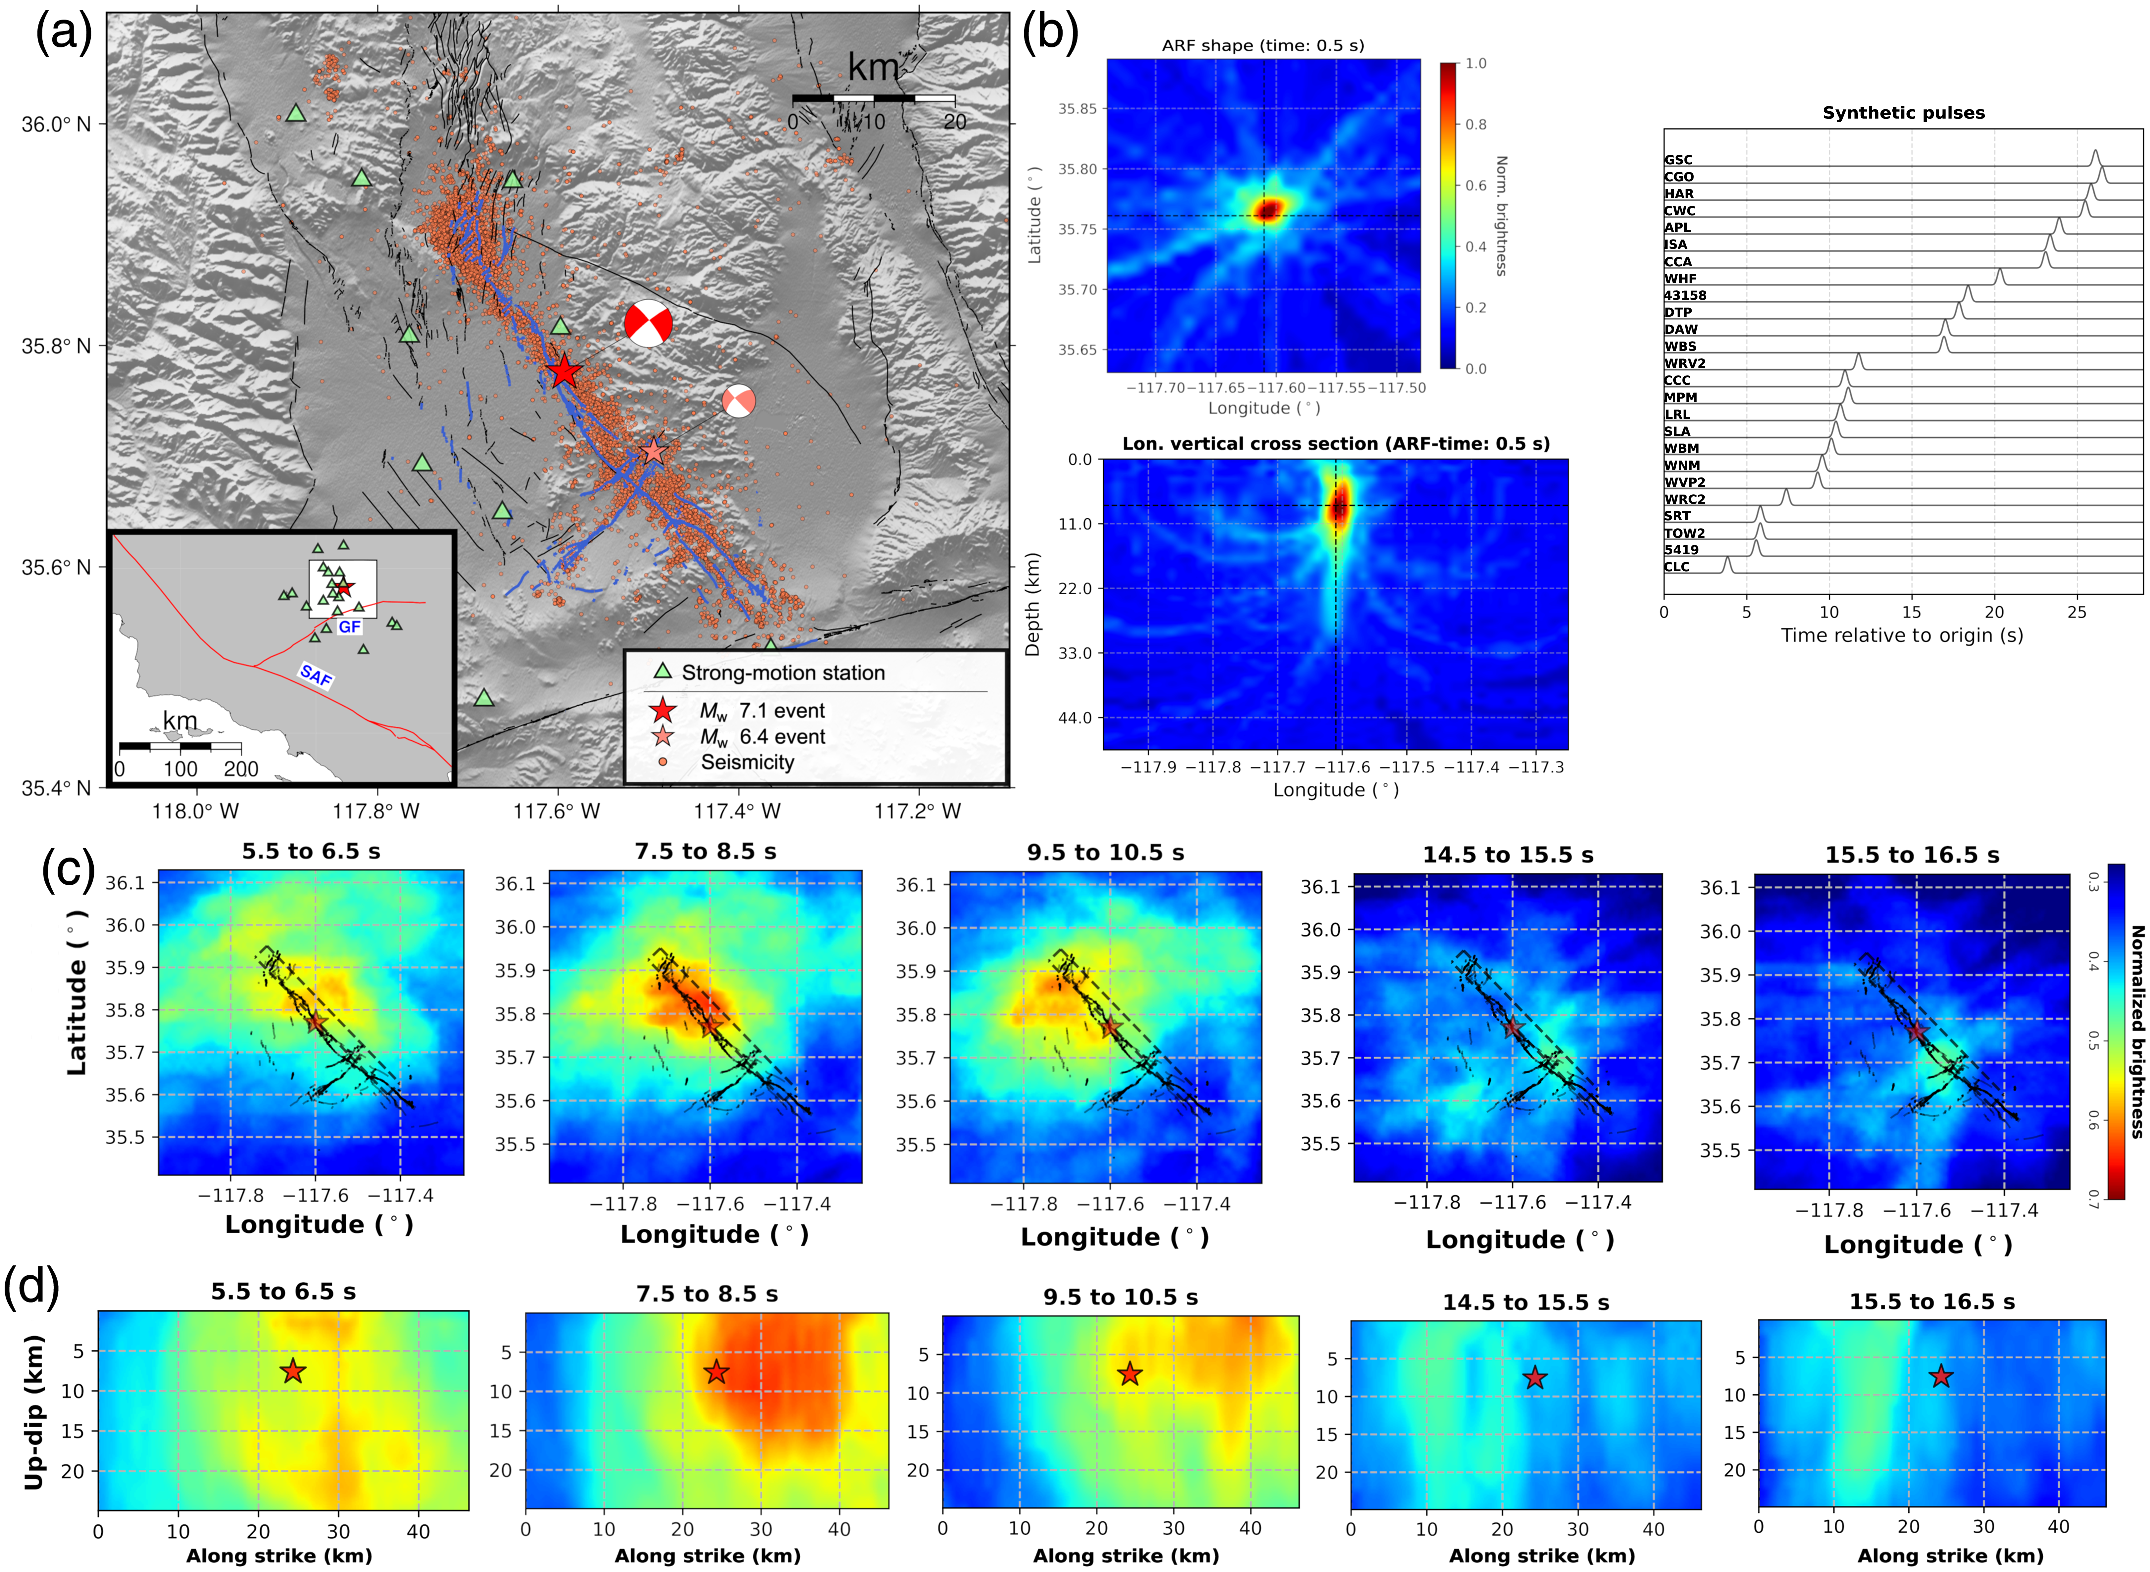

SSA2py results for the  7.1 Ridgecrest seismic event: (a) general tectonic map for the region with faults (black lines) from the Quaternary Fault and Fold Database of the United States (USGS, 2020) and with ruptures produced from the sequence (blue lines; Ponti et al., 2020). The red star denotes the epicenter of the main seismic event (⁠7.1), the salmon star the foreshock (⁠6.4), and the green colored triangles are the strong‐motion stations used. Aftershock activity with orange circles is from Ross et al. (2019). The focal solutions and the hypocenters of the events were retrieved from U.S. Geological Survey (USGS). The inset map presents the location of the event relative to the SAF and the Garlock fault segment (GF). (b) Plots of the array response function (ARF) test results for the used station distribution, which include the ARF shape in map view and in cross section at the maximum brightness timestep (0.5 s) and the used synthetic pulses. Selected map view plot of the (c) maximum observed brightness at all depths and (d) along strike and dip cross sections.

The rupture spread in both the directions, reaching ∼15 km away from the epicenter in the northern part of the activated fault. This expansion continued until around 10 s after the origin. The maximum HF radiation was in this area 7–8 s after the origin. After that the rupture process was expanded 15–20 km southwest of the epicenter with continuously decreasing energy and ended ≈18 s after the origin.

# 5. SSA2py Workflow

SSA2py was designed with the aim of maintaining a simple but at the same time efficient workflow.

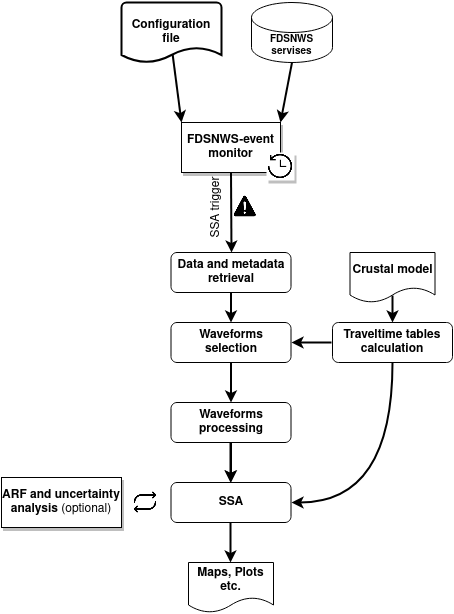

To automatically implement SSA2py, these sequential steps are typically taken:

1. **Check for new events**

Monitoring FDSNWS-event services trying to identify new seismic events. In case of a seismic event that complies to the user given criteria the SSA2py initiates. Inside the configuration file there is a special section dedicated to event restrictions in order to avoid false triggers or mislocated seismic events.

2. **Select Inventory/Waveforms**

In a case of seismic event, SSA2py tries to gather all the available data/metadata information from various user given sources. For station metadata SSA2py can gather info from FDSNWS-station services, local StationXML files or StationYAML files (yaml type files oriented mainly for manual SSA2py applications). For seismic waveforms SSA2py can look in Seedlink (near-real time application), FDSNWS-dataselect services, data in SDS and MSEED format.

Erroneous waveforms can be automatically discarded from the process by applying various quality check methods (SNR, CLIP, TIME).

3. **Waveforms processing/Travel-Time tables**

The user can easily adapt the SSA application based to his/her needs by using different waveforms processing approaches. A variety of options for filtering, rotation, normalization, change waveforms type etc is offered. Also the Travel-Time tables necessary for the SSA application are calculated. Except from the classical 1-D model implementation SSA2py offers also 3-D velocity model option.

4. **SSA Calculations**

In the next step SSA2py calculates SSA in time for an adjustable 4-D grid. Uncertainty analysis tests can be performed (Jackknife, Bootstrap, Array Response Function) if the user enables these options.

5. **Results analysis**

Results analysis plots.


# Relevant references:

Ioannis Fountoulakis, Christos P. Evangelidis; SSA2py: A High‐Performance Python Implementation of the Source‐Scanning Algorithm for Spatiotemporal Seismic Source Imaging. Seismological Research Letters 2024; 95 (4): 2506–2518. doi: https://doi.org/10.1785/0220230335

# More about SSA2py

https://ssa2py.readthedocs.io/en/latest/methodology.html

https://github.com/ifountoul/SSA2py